In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd()))

import numpy as np
import matplotlib.pyplot as plt
import torch

from red_diffeq.utils.data_trans import v_normalize, v_denormalize
from red_diffeq.utils.ssim import SSIM

Loaded three results:
  Result 1 shape: (70, 190)


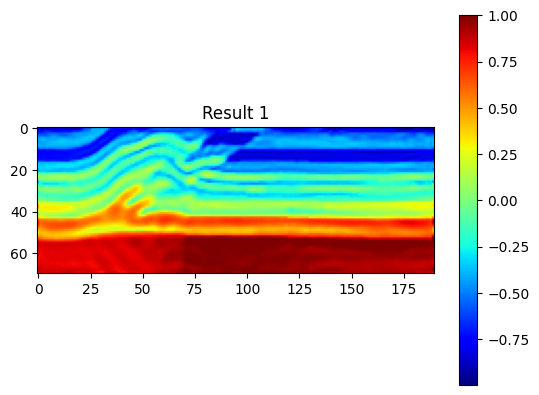

In [8]:
result = np.load('experiment/Overthrust/overthrust_red_diffeq/20251209_162531/overthrust/0_results.npz')


ssim  = result['ssim']
vm = result['result']

print("Loaded three results:")
print(f"  Result 1 shape: {vm.shape}")

plt.imshow(vm, cmap='jet', aspect='equal')
plt.colorbar()
plt.title('Result 1')
plt.show()


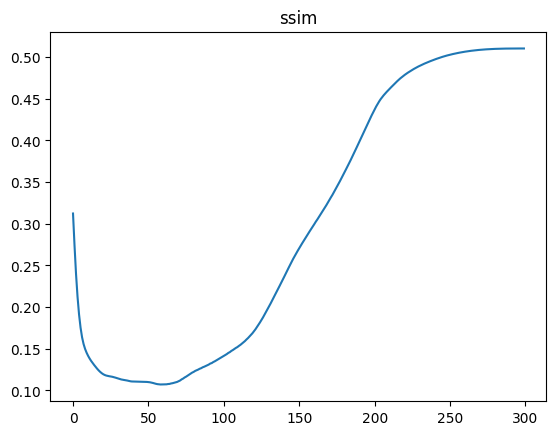

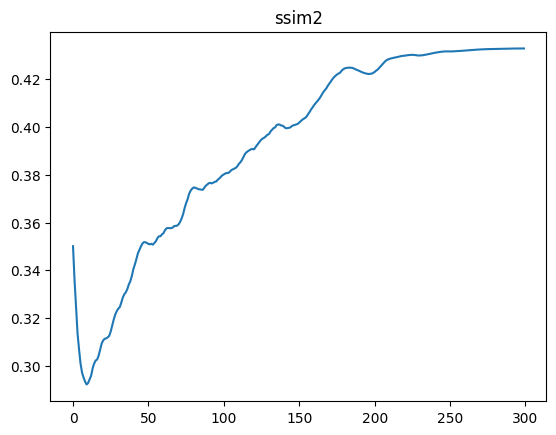

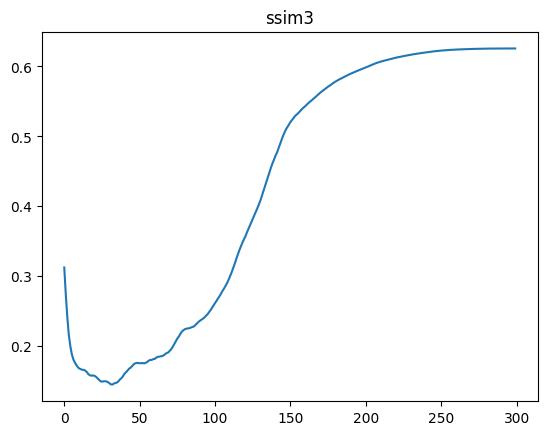

In [21]:
plt.plot(ssim)
plt.title('ssim')
plt.show()

plt.plot(ssim2)
plt.title('ssim2')
plt.show()  

plt.plot(ssim3)
plt.title('ssim3')
plt.show()


In [15]:
# Load ground truth for Marmousi
gt_path = Path('dataset/Marmousi/Velocity_Data/marmousi.npy')
gt_data = np.load(gt_path, mmap_mode='r')
print(f"GT data shape: {gt_data.shape}")

# Extract first sample (Marmousi has shape (1, 1, 70, 190))
if gt_data.ndim == 4:
    gt_2d = gt_data[0, 0].copy()  # Shape: (70, 190)
else:
    gt_2d = gt_data[0].copy()

print(f"GT 2D shape: {gt_2d.shape}")
print(f"GT range: [{gt_2d.min():.2f}, {gt_2d.max():.2f}] (m/s)")
print(f"Result 1 range: [{vm.min():.4f}, {vm.max():.4f}]")
print(f"Result 2 range: [{vm2.min():.4f}, {vm2.max():.4f}]")
print(f"Result 3 range: [{vm3.min():.4f}, {vm3.max():.4f}]")

# Initialize SSIM calculator
ssim_calc = SSIM(window_size=11, size_average=True)


GT data shape: (1, 1, 70, 190)
GT 2D shape: (70, 190)
GT range: [1500.00, 4500.00] (m/s)
Result 1 range: [-1.0000, 0.8888]
Result 2 range: [-1.0000, 1.0000]
Result 3 range: [-1.0000, 1.0000]


In [16]:
# Determine if results are normalized or denormalized based on their range
# Normalized: range should be approximately [-1, 1]
# Denormalized: range should be approximately [1500, 4500] m/s

def check_and_normalize(result_data, gt_data, name):
    """Check data range and normalize if needed, then compute SSIM.
    
    Handles dimension mismatches by cropping GT to match result dimensions.
    """
    result_min, result_max = result_data.min(), result_data.max()
    
    # Check dimensions and crop GT if needed
    result_h, result_w = result_data.shape
    gt_h, gt_w = gt_data.shape
    
    if result_h != gt_h or result_w != gt_w:
        print(f"  ⚠️  Dimension mismatch: Result {result_data.shape} vs GT {gt_data.shape}")
        # Crop GT to match result (center crop)
        h_diff = gt_h - result_h
        w_diff = gt_w - result_w
        
        h_start = h_diff // 2
        h_end = gt_h - (h_diff - h_diff // 2)
        w_start = w_diff // 2
        w_end = gt_w - (w_diff - w_diff // 2)
        
        gt_cropped = gt_data[h_start:h_end, w_start:w_end]
        print(f"  → Cropped GT from {gt_data.shape} to {gt_cropped.shape}")
    else:
        gt_cropped = gt_data
    
    # Check if result appears to be normalized (typical range [-1, 1] or close)
    is_normalized = abs(result_max) <= 2.0 and abs(result_min) <= 2.0
    
    print(f"\n{name}:")
    print(f"  Result shape: {result_data.shape}, range: [{result_min:.4f}, {result_max:.4f}]")
    
    if is_normalized:
        print(f"  → Result appears to be NORMALIZED (range ~[-1, 1])")
        result_norm = result_data
    else:
        print(f"  → Result appears to be DENORMALIZED (physical units), normalizing...")
        # Normalize the result
        result_norm = v_normalize(result_data)
        print(f"  → Normalized result range: [{result_norm.min():.4f}, {result_norm.max():.4f}]")
    
    # Normalize ground truth (use cropped version)
    gt_norm = v_normalize(gt_cropped)
    print(f"  GT (cropped) range: [{gt_cropped.min():.2f}, {gt_cropped.max():.2f}] m/s")
    print(f"  Normalized GT range: [{gt_norm.min():.4f}, {gt_norm.max():.4f}]")
    
    # Verify dimensions match after normalization
    assert result_norm.shape == gt_norm.shape, f"Shape mismatch after normalization: {result_norm.shape} vs {gt_norm.shape}"
    
    # Convert to tensors for SSIM calculation
    # SSIM expects [0, 1] range, so convert from [-1, 1]
    result_tensor = torch.from_numpy(result_norm[np.newaxis, np.newaxis, ...]).float()
    gt_tensor = torch.from_numpy(gt_norm[np.newaxis, np.newaxis, ...]).float()
    
    # Convert to [0, 1] range for SSIM
    result_01 = (result_tensor + 1) / 2
    gt_01 = (gt_tensor + 1) / 2
    
    # Calculate SSIM
    ssim_val = ssim_calc(result_01, gt_01).item()
    
    return ssim_val, result_norm, gt_norm

# Compute SSIM for all three results
ssim1, vm1_norm, gt_norm = check_and_normalize(vm, gt_2d, "Result 1 (20251206_225948)")
ssim2, vm2_norm, gt_norm2 = check_and_normalize(vm2, gt_2d, "Result 2 (20251206_223032)")
ssim3, vm3_norm, gt_norm3 = check_and_normalize(vm3, gt_2d, "Result 3 (20251208_113822)")

# Print SSIM results
print("\n" + "="*70)
print("SSIM Results Summary:")
print("="*70)
print(f"Result 1 (20251206_225948): SSIM = {ssim1:.6f}")
print(f"Result 2 (20251206_223032): SSIM = {ssim2:.6f}")
print(f"Result 3 (20251208_113822): SSIM = {ssim3:.6f}")
print("="*70)



Result 1 (20251206_225948):
  Result shape: (70, 190), range: [-1.0000, 0.8888]
  → Result appears to be NORMALIZED (range ~[-1, 1])
  GT (cropped) range: [1500.00, 4500.00] m/s
  Normalized GT range: [-1.0000, 1.0000]

Result 2 (20251206_223032):
  Result shape: (70, 190), range: [-1.0000, 1.0000]
  → Result appears to be NORMALIZED (range ~[-1, 1])
  GT (cropped) range: [1500.00, 4500.00] m/s
  Normalized GT range: [-1.0000, 1.0000]
  ⚠️  Dimension mismatch: Result (68, 188) vs GT (70, 190)
  → Cropped GT from (70, 190) to (68, 188)

Result 3 (20251208_113822):
  Result shape: (68, 188), range: [-1.0000, 1.0000]
  → Result appears to be NORMALIZED (range ~[-1, 1])
  GT (cropped) range: [1526.69, 4500.00] m/s
  Normalized GT range: [-0.9822, 1.0000]

SSIM Results Summary:
Result 1 (20251206_225948): SSIM = 0.785123
Result 2 (20251206_223032): SSIM = 0.801043
Result 3 (20251208_113822): SSIM = 0.490800
